### Bootstrapping Ridge Regression and Lasso

## Objectives

As we learned this week, Ridge Regression and LASSO Regression are regularized models. In this Jupyter notebook, we will see how AUROC changes on the test set by varying the regularization parameter. We will use a technique called bootstrapping to get 95% confidence intervals for our results. Therefore, this week we learn:
* Bootstrapping
* Effect of regularization parameter on Ridge Regression and LASSO Regression

## Preparing the Data

Before importing the data, as usual, we import _pandas_ library to simplify data manipulation.

In [1]:
import pandas as pd

In this discussion, we again use _Hitters_ dataset which is the data collected from Major League Baseball (MLB) data from the 1986 and 1987 seasons. We want to predict the new league of each player at the end of the season based on their performance in the previous league. For more information on the dataset, please look it up!

In [2]:
#the data can be downloaded from "https://github.com/jcrouser/islr-python/blob/master/data/Hitters.csv"
df = pd.read_csv('Hitters.csv')

We now print out the dataset to gain more insight in it:

In [3]:
print (df.head(10))

              Player  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  \
0     -Andy Allanson    293    66      1    30   29     14      1     293   
1        -Alan Ashby    315    81      7    24   38     39     14    3449   
2       -Alvin Davis    479   130     18    66   72     76      3    1624   
3      -Andre Dawson    496   141     20    65   78     37     11    5628   
4  -Andres Galarraga    321    87     10    39   42     30      2     396   
5   -Alfredo Griffin    594   169      4    74   51     35     11    4408   
6         -Al Newman    185    37      1    23    8     21      2     214   
7   -Argenis Salazar    298    73      0    24   24      7      3     509   
8     -Andres Thomas    323    81      6    26   32      8      2     341   
9    -Andre Thornton    401    92     17    49   66     65     13    5206   

   CHits  ...  CRuns  CRBI  CWalks  League Division PutOuts  Assists  Errors  \
0     66  ...     30    29      14       A        E     446       33    

In many realworld datasets, the value for some features for some data points is missing. There are many ways of handling such missing values. Such methods are called _imputation_. Here, we remove all the rows containing any missing value. We use a function named _dropna_ which is defined in _pandas_ library.

In [4]:
df.dropna(inplace=True)

As discussed above, the _new leage_ column in the dataset will be our label and others will be our features. We select all the columns, except for _NewLeague_, as our features and select _NewLeague_ as our label.

In [5]:
X = df[['AtBat','Hits','HmRun','Runs','RBI','Walks','Years','CAtBat','CHits','CHmRun','CRuns','CRBI','CWalks','League','Division','PutOuts','Assists','Errors','Salary']]
y = df[['NewLeague']]

Many models assume their input variables to be in numeric format. Nonetheless, many datasets have categorical data which cannot be directly into such models. In order to process them into the right format, we perform _one hot encoding_. In case you are not familiar with this process, please look it up!
<br>
We select all the categorical columns of _X_ by selecting the columns with data types not _integer_ and _float_. Then we use _get_dummies_ function which one hot encodes the data for us. At the end we concatenate all the features to have a fully numerical feature set.

In [6]:
X_cat = X.select_dtypes(exclude=['int64', 'float64'])                                                                                                         
X_dog = X.select_dtypes(include=['int64', 'float64'])                                                                                                         
                                                                                                                                                              
X_cat = pd.get_dummies(X_cat)                                                                                                                                 
X = pd.concat([X_cat, X_dog], axis=1)   

In [7]:
X

,League_A,League_N,Division_E,Division_W,AtBat,Hits,HmRun,Runs,RBI,Walks,...,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
1,0,1,0,1,315,81,7,24,38,39,...,3449,835,69,321,414,375,632,43,10,475.0
2,1,0,0,1,479,130,18,66,72,76,...,1624,457,63,224,266,263,880,82,14,480.0
3,0,1,1,0,496,141,20,65,78,37,...,5628,1575,225,828,838,354,200,11,3,500.0
4,0,1,1,0,321,87,10,39,42,30,...,396,101,12,48,46,33,805,40,4,91.5
5,1,0,0,1,594,169,4,74,51,35,...,4408,1133,19,501,336,194,282,421,25,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0,1,1,0,497,127,7,65,48,37,...,2703,806,32,379,311,138,325,9,3,700.0
318,1,0,1,0,492,136,5,76,50,94,...,5511,1511,39,897,451,875,313,381,20,875.0
319,1,0,0,1,475,126,3,61,43,52,...,1700,433,7,217,93,146,37,113,7,385.0
320,1,0,1,0,573,144,9,85,60,78,...,3198,857,97,470,420,332,1314,131,12,960.0


Nearly all models in Python accept the labels as numerical values as well. Therefore, in classification tasks, the common practice is changing the name of the outputs to numbers from $0$ to $k-1$ with $k$ being the number of different classes. Here, we have two classes, _A_ and _N_, which we will convert to 0 and 1 respectively.

In [8]:
NewLeague2number_dict = {
    'A':0,
    'N':1
}

y=y.replace({"NewLeague": NewLeague2number_dict})

### Ridge Regression

As we learned in the class, the loss function for ridge regression can be written as:

$\sum_{p=1}^P (y_p - w_0 - \sum_{j=1}^N w_j x_{pj} ) ^2 + \lambda \sum_{j=1}^N w_j^2 = RSS + \lambda \sum_{j=1}^N w_j^2$

which can be seen as a linear regression with a regularization term $\sum_{j=1}^N w_j^2$. With varying $\lambda$ from $0$ to $\infty$, we go from minimizing just the $RSS$ to minimizing $\sum_{j=1}^N w_j^2$. The former is prone to overfitting and the latter would give the trivial answer of all 0 weights. The correct answer, however, is somewhere between the two extremes which needs to be found using cross validation/bootstrapping.\\

We will see how our results change for a few different $\lambda$ values.

### LASSO Regression

As also noted in the class, the loss function for LASSO regression can be written as:

$\sum_{p=1}^P (y_p - w_0 - \sum_{j=1}^N w_j x_{pj} ) ^2 + \lambda \sum_{j=1}^N | w_j | = RSS + \lambda \sum_{j=1}^N | w_j |$

which can also be seen as a linear regression with a regularization term $\sum_{j=1}^N | w_j |$. With varying $\lambda$ from $0$ to $\infty$, we go from minimizing just the $RSS$ to minimizing $\sum_{j=1}^N | w_j |$. Similar to ridge regression, the former is prone to overfitting and the latter would give the trivial answer of all 0 weights. The correct answer, however, is somewhere between the two extremes which needs to be found using cross validation/bootstrapping.\\

We will see how our results change for a few different $\lambda$ values.

### Bootstrapping

Bootstrapping is a statistical apprpoach done by random sampling with replacement. Each time, we split the data into training set and testing set separately and try to find the best value of $\lambda$ for our regression problem bootstrapping. We select the best value using the mean error on the test set and then plot confidence intervals using the results at hand. 

We first start by writing a function that for a fixed train/test split, computes AUCs for all different lambda values for each of the models:

In [9]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import roc_auc_score

max_iter = 1e8

def lambda_aucs (model, lambda_vals, x_train, y_train, x_test, y_test):
    auc = []
    
    for lambda_ in lambda_vals:
        
        if model== "ridge":
            estimator = Ridge(max_iter = max_iter, alpha = lambda_)
        elif model == "lasso":
            estimator = Lasso(max_iter = max_iter, alpha = lambda_)
        
        estimator.fit(x_train, y_train)
        preds = estimator.predict(x_test)
        
        auc.append(roc_auc_score(y_test, preds))

    return auc

Now we perform the bootstrapping:

In [10]:
import numpy as np

n_bootstraps = int(1e3)

n_test  = int(0.2*len(X))
n_train = len(X) - n_test

lambda_vals = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

aucs         = {"ridge":[], "lasso":[]}

for _ in range(n_bootstraps):
    train_test_indicator = np.asarray([True]*n_train + [False]*n_test)
    np.random.shuffle(train_test_indicator)
    
    x_train, x_test, y_train, y_test = X[train_test_indicator], X[np.logical_not(train_test_indicator)], y[train_test_indicator], y[np.logical_not(train_test_indicator)]
    
    ridge_lambda_auc = lambda_aucs ("ridge", lambda_vals, x_train, y_train, x_test, y_test)
    lasso_lambda_auc = lambda_aucs ("lasso", lambda_vals, x_train, y_train, x_test, y_test)
    
    aucs ["ridge"].append(ridge_lambda_auc)
    aucs ["lasso"].append(lasso_lambda_auc)

We plot the first 20 AUC vs lambda value curves:

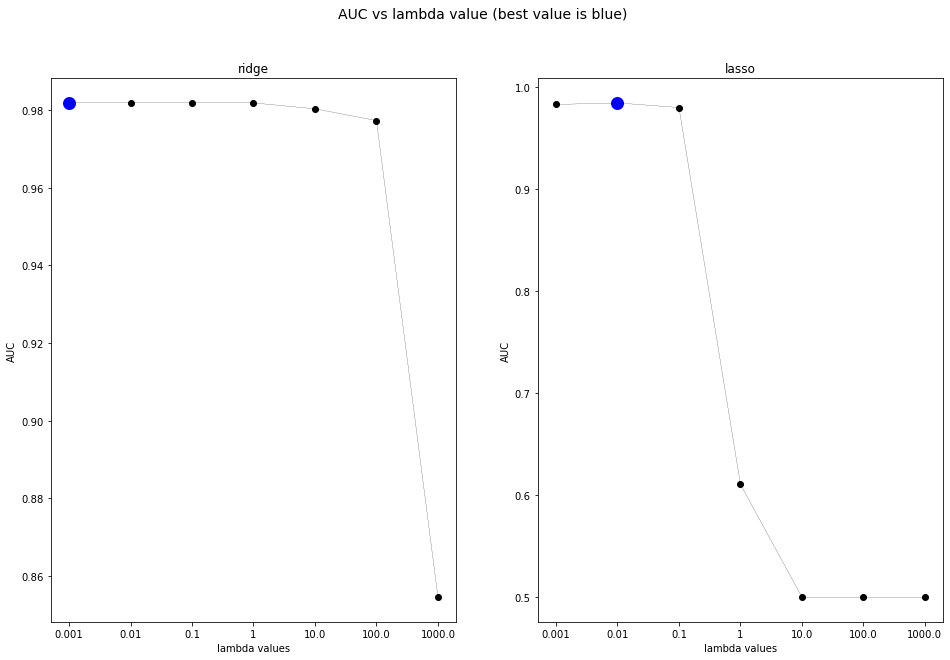

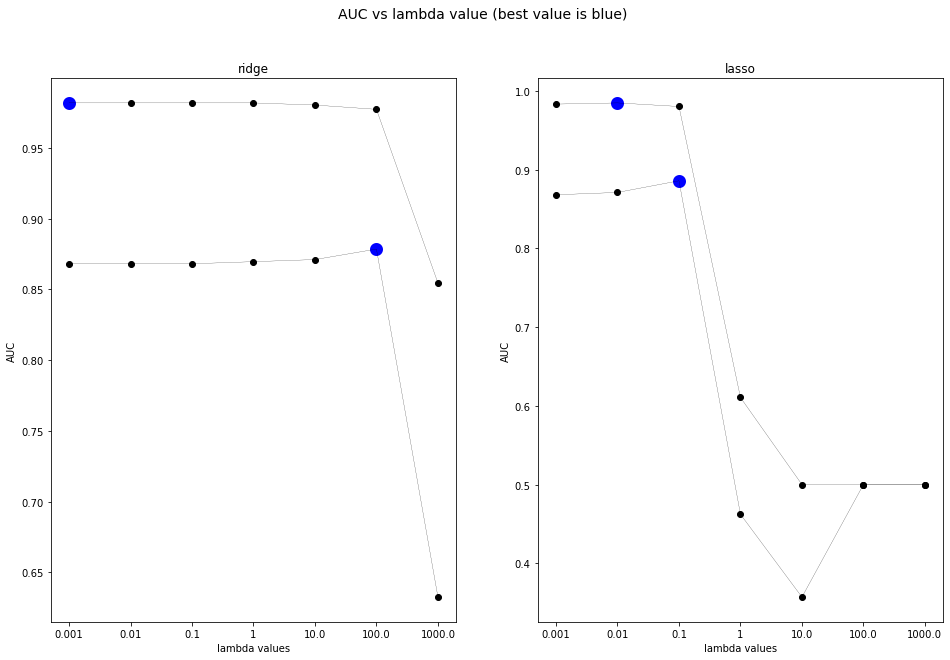

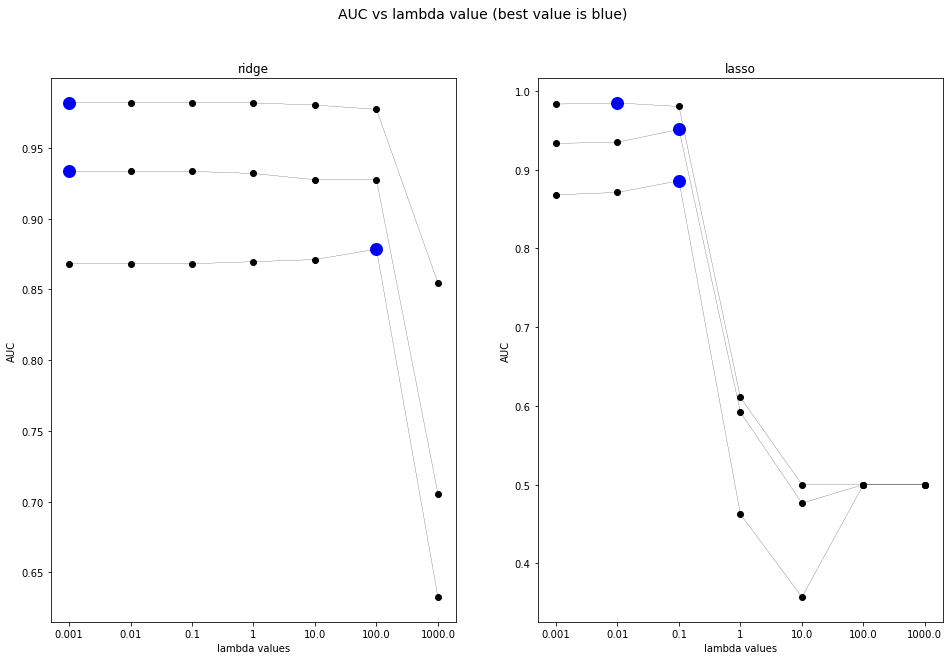

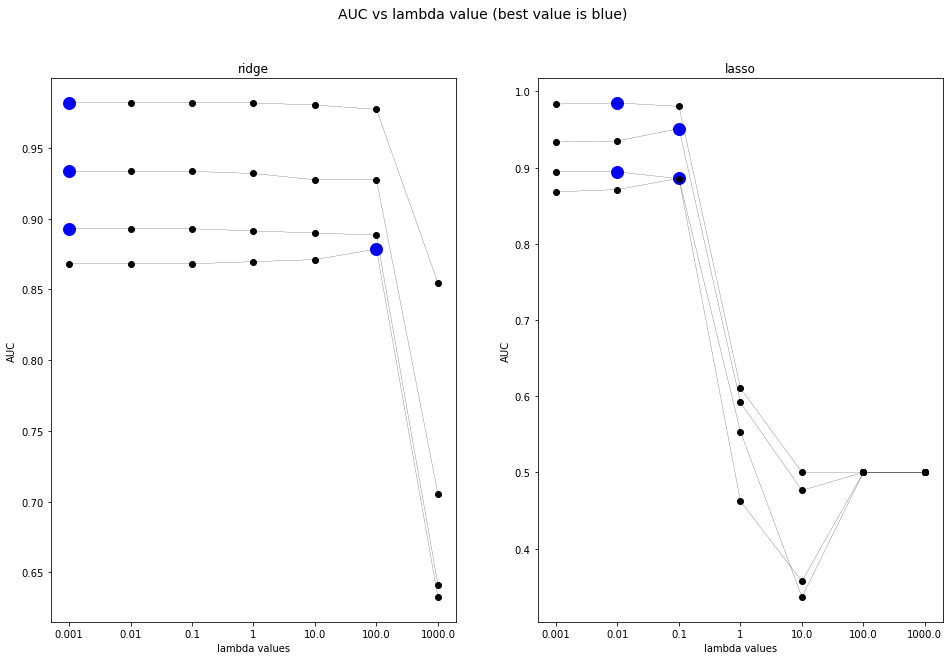

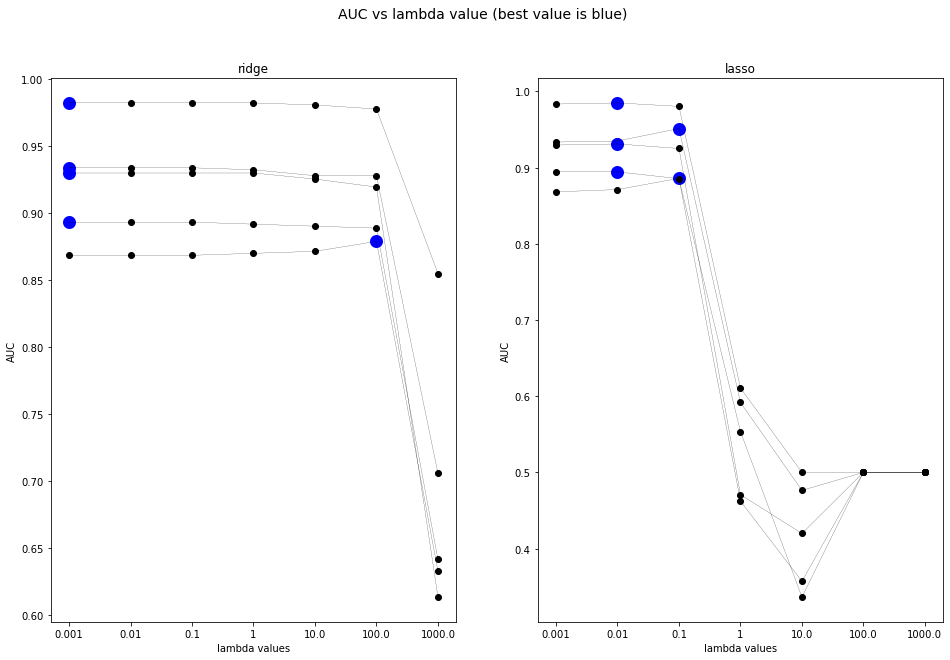

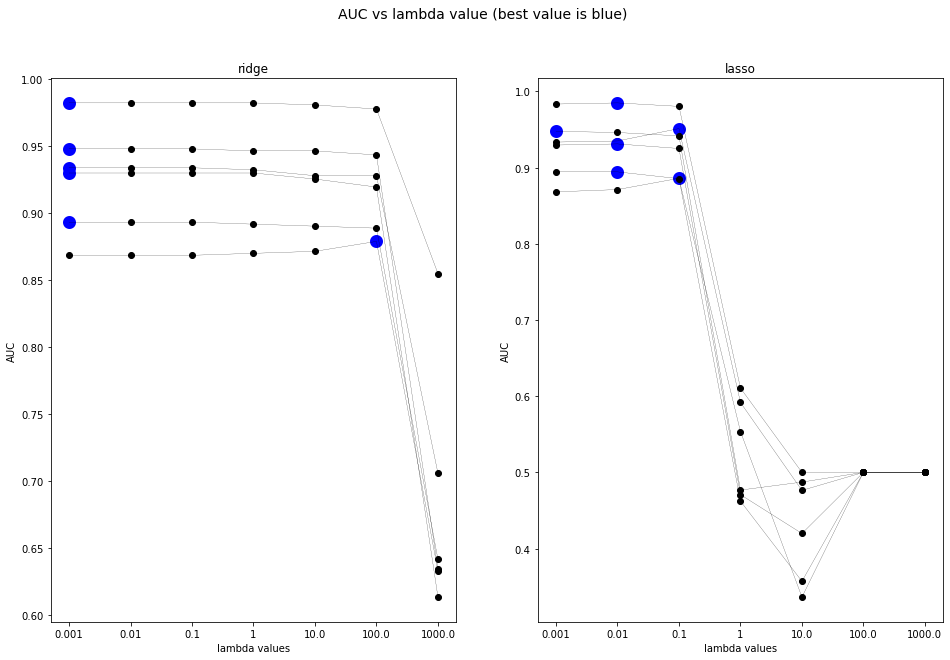

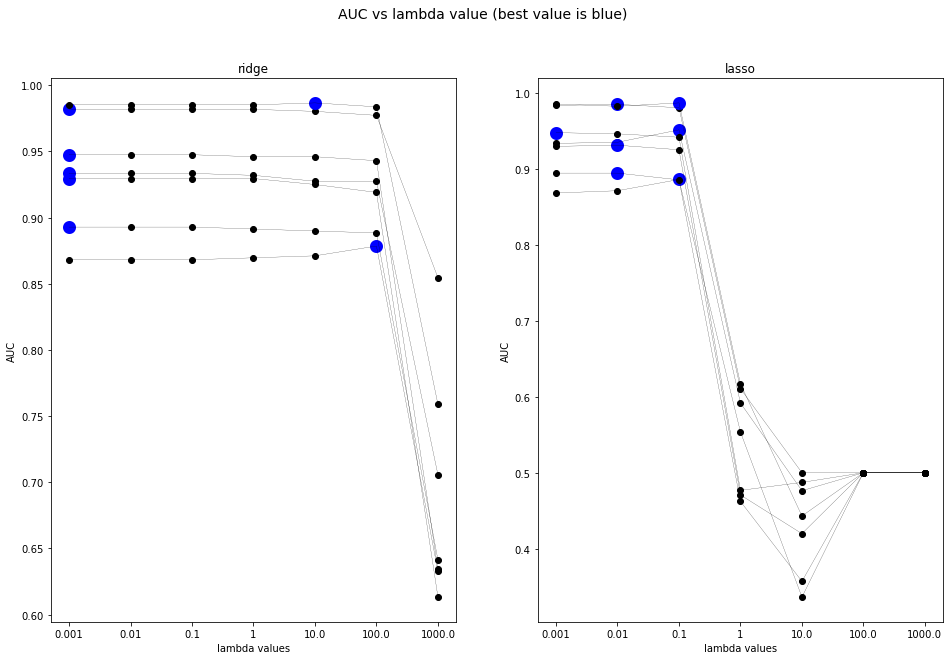

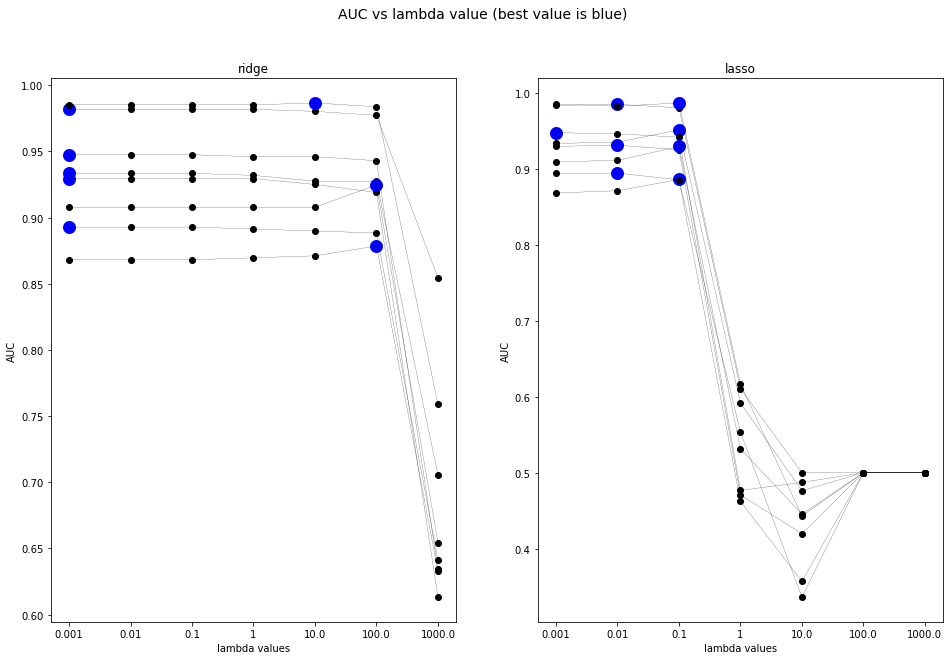

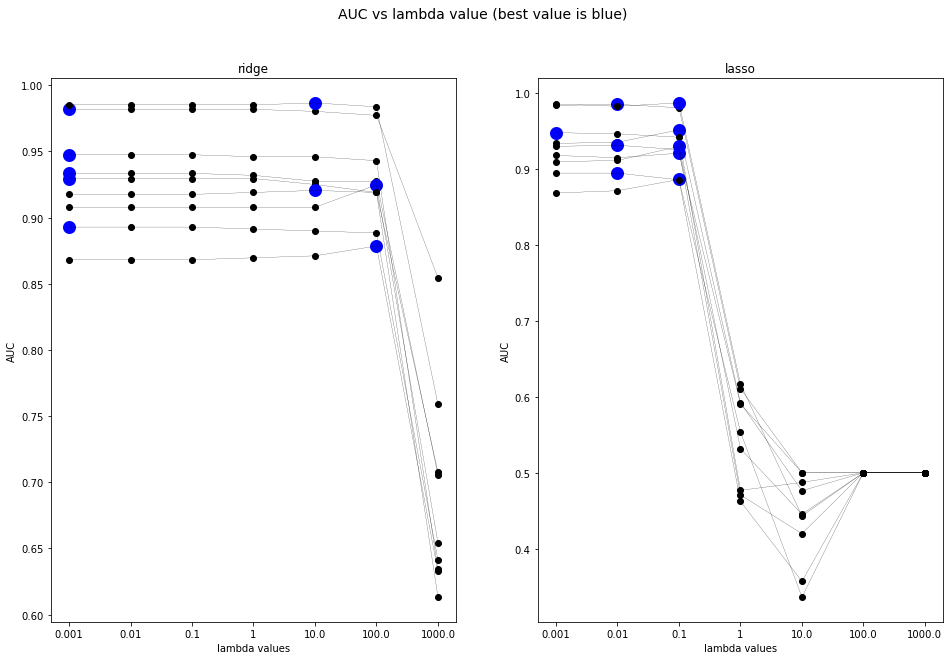

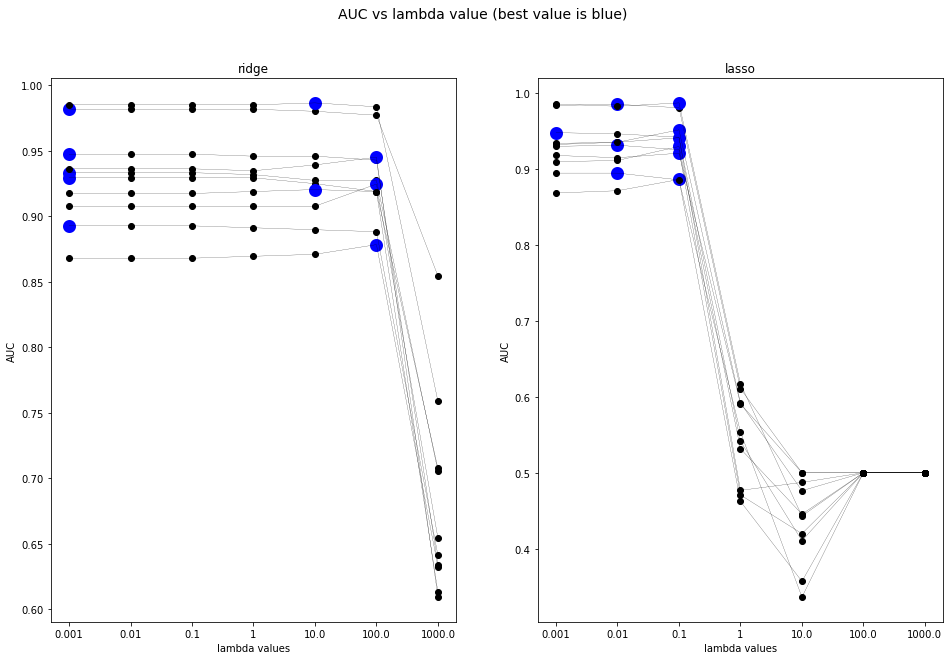

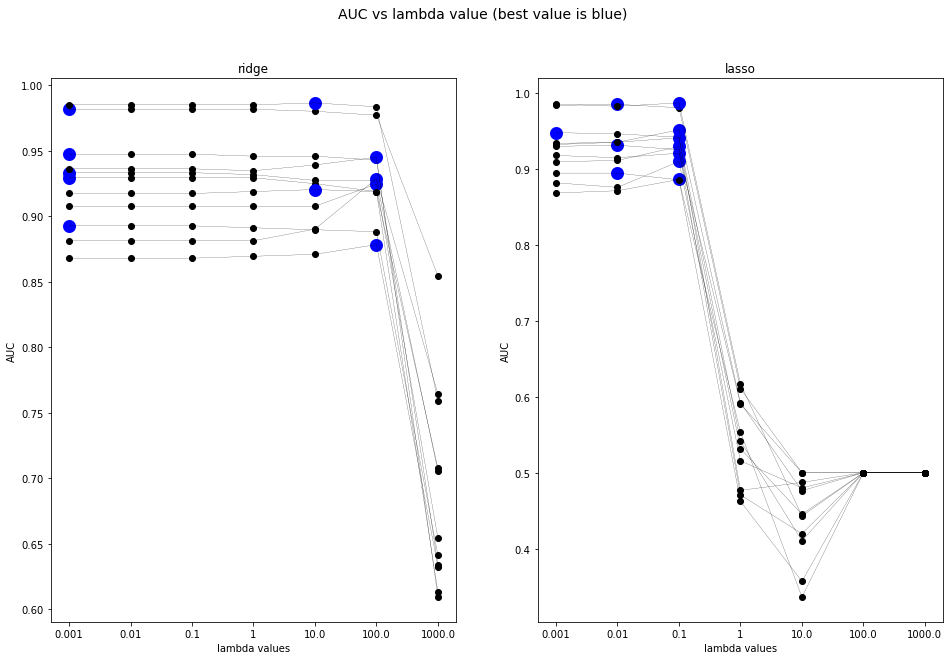

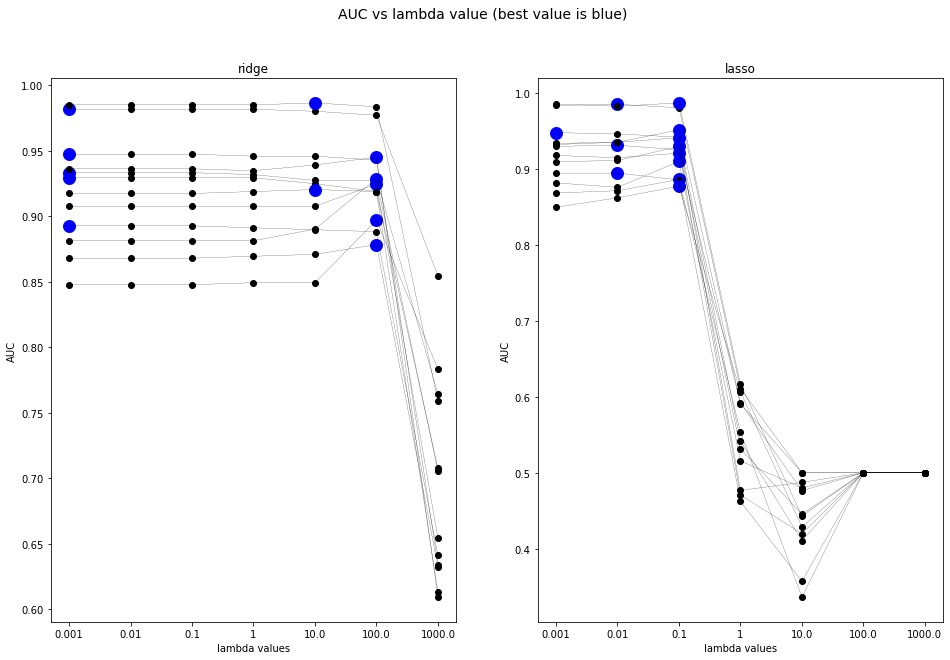

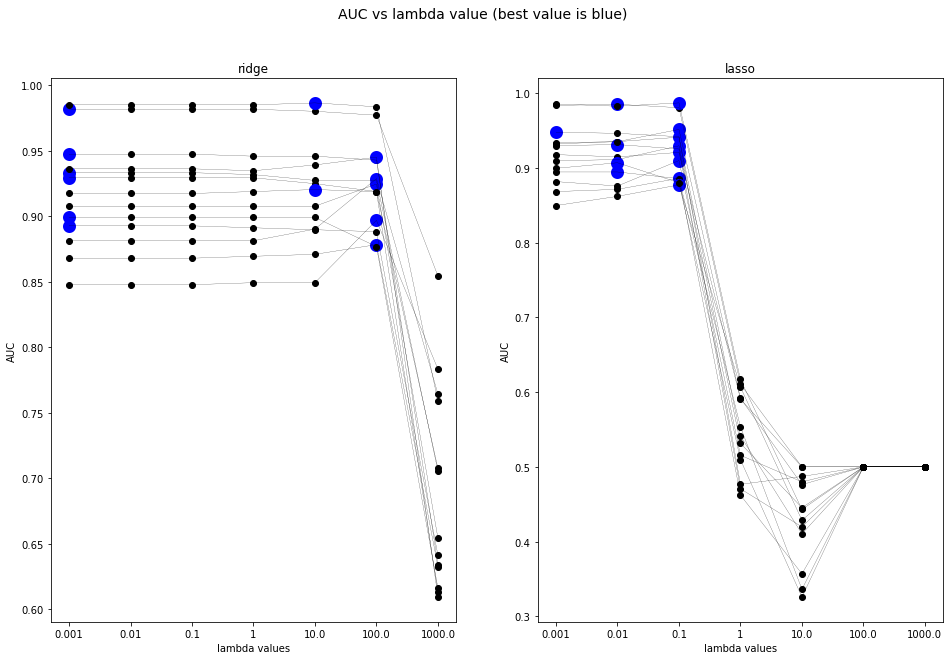

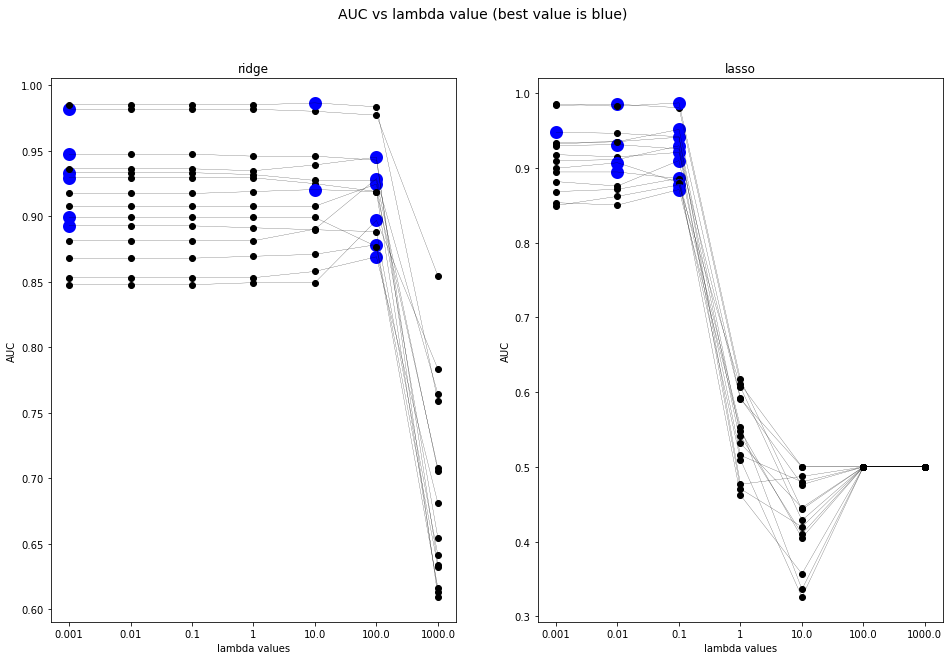

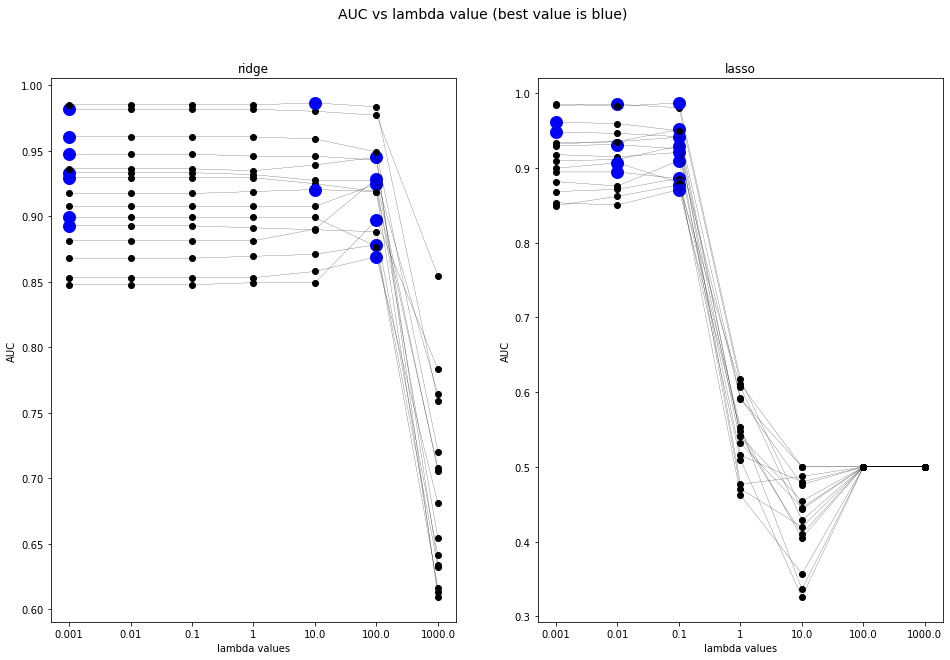

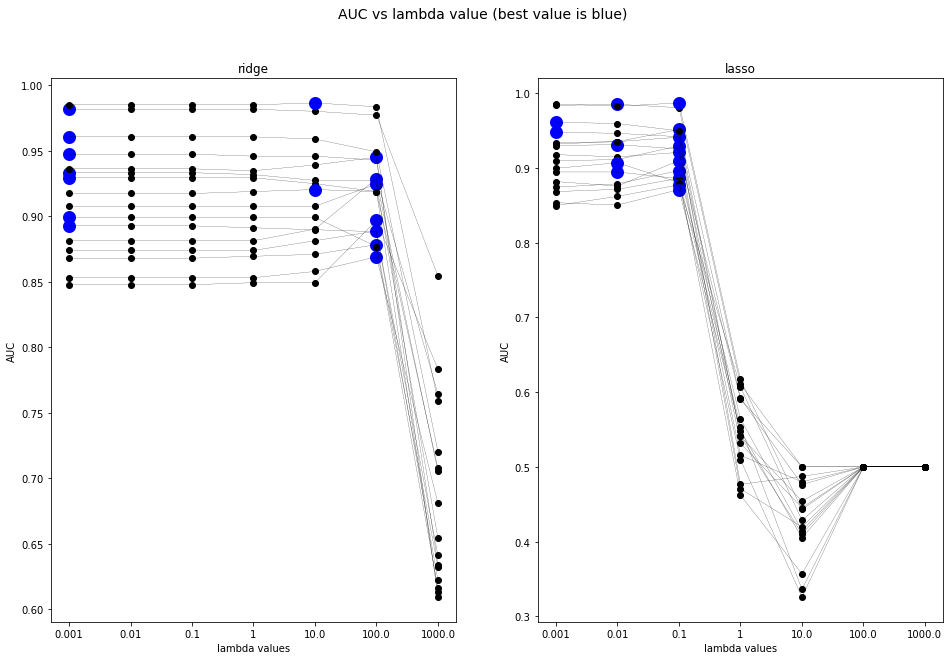

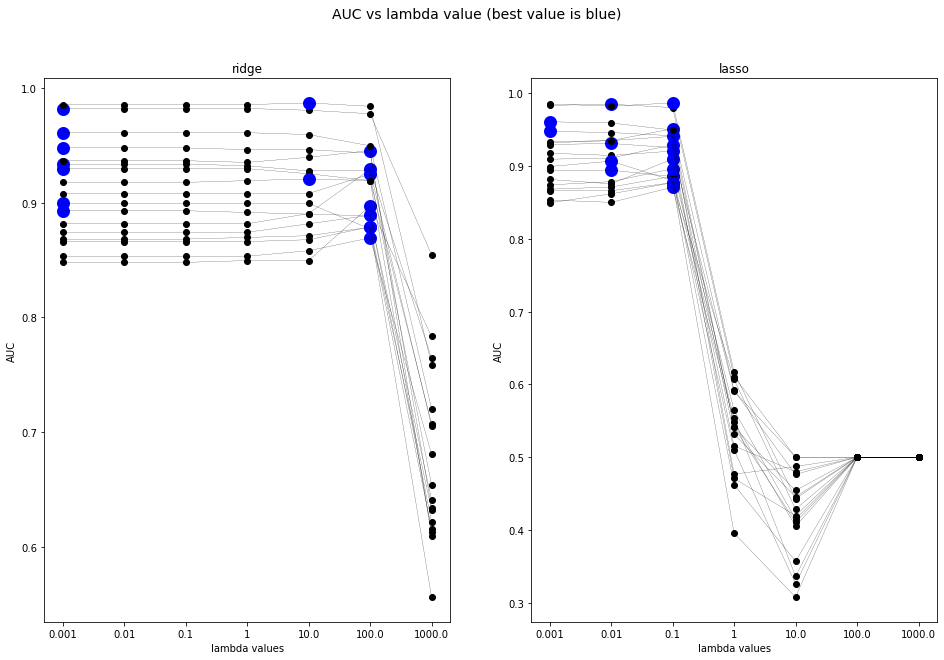

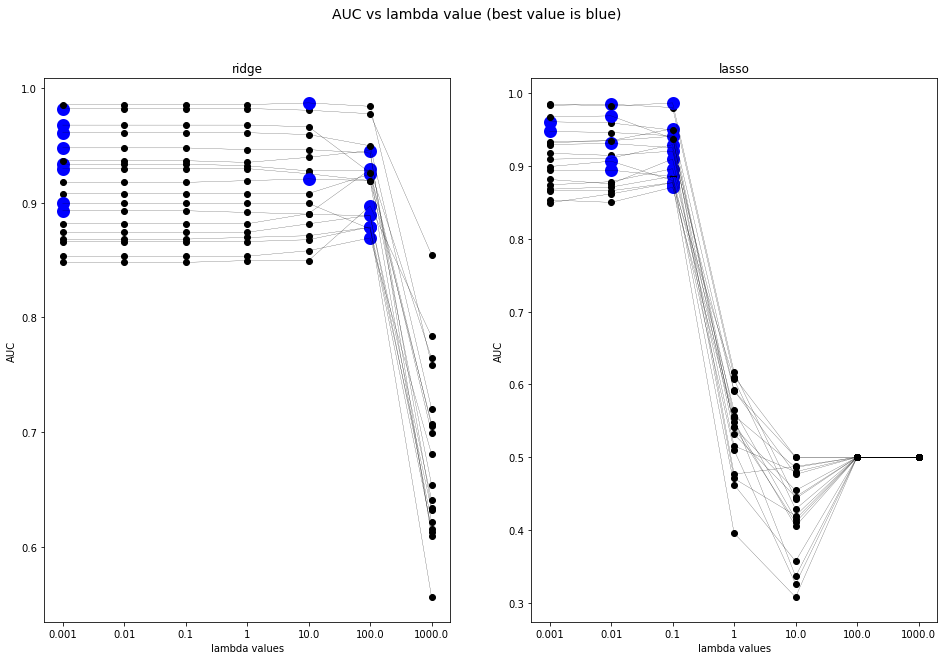

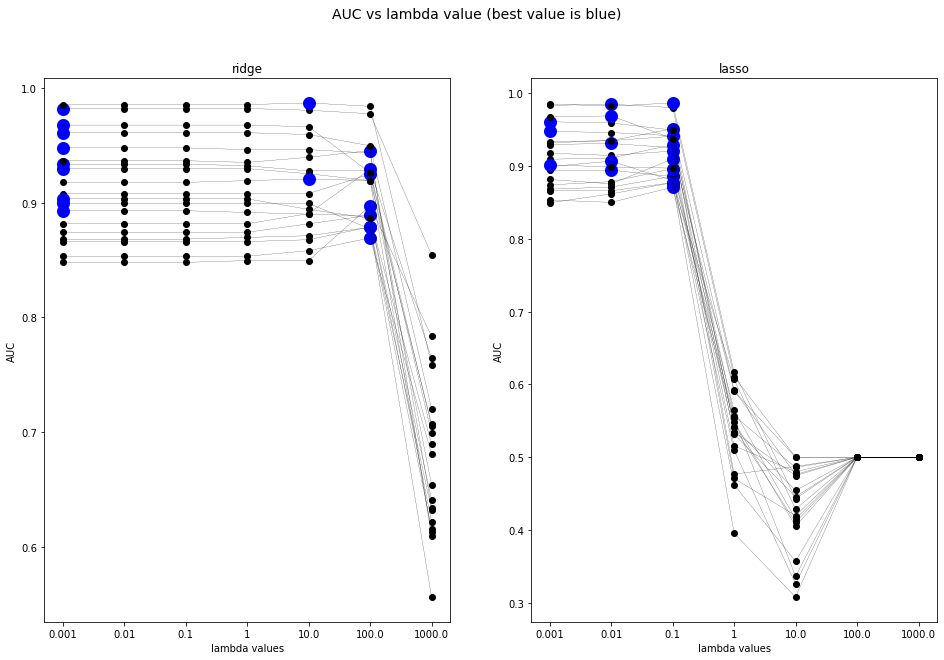

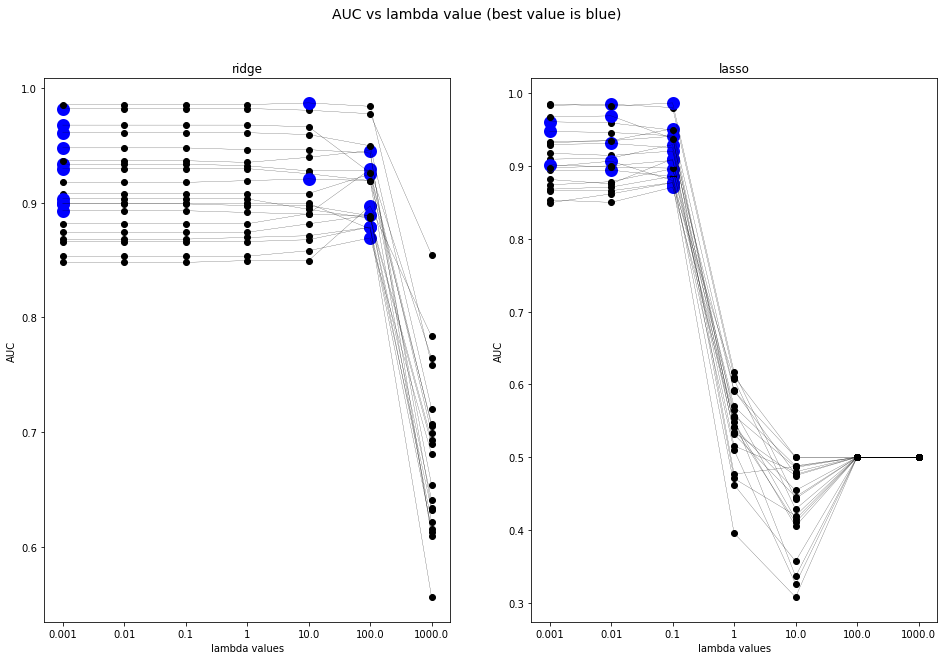

In [11]:
import matplotlib.pyplot as plt


def plot_auc_subplot(ax, auc, model):
    best_lambda_index = np.argmax(auc)
    ax.scatter(range(1, len(auc)+1), auc, color='black')
    ax.plot(range(1, len(auc)+1), auc, linewidth=0.2, color = 'black')
    ax.scatter(best_lambda_index+1, auc[best_lambda_index], color='blue', linewidth=7)
    
    plt.sca(ax)
    plt.title(model)
    plt.xlabel('lambda values')
    plt.xticks(range(1, len(lambda_vals)+1), lambda_vals)
    plt.ylabel('AUC')
    

for i in range(1,21):
    fig, axs = plt.subplots(1,2,figsize=(16,10))
    fig.suptitle("AUC vs lambda value (best value is blue)", fontsize=14)
    for j in range(i):
        auc_ridge = np.asarray(aucs["ridge"][j])
        auc_lasso = np.asarray(aucs["lasso"][j])

        plot_auc_subplot(axs[0], auc_ridge, "ridge")
        plot_auc_subplot(axs[1], auc_lasso, "lasso")


To get the mean value for all the different lambda values, we will make a dataframe from all the results from each and then take the mean of the values:

In [12]:
ridge_aucs=pd.DataFrame(aucs["ridge"])
lasso_aucs=pd.DataFrame(aucs["lasso"])

We can see the mean AUC for both the models:

In [13]:
print ("ridge mean AUCs:")
for lambda_val, ridge_auc in zip(lambda_vals, ridge_aucs.mean()):
    print (lambda_val, "AUC:", "%.2f"%ridge_auc)
    
    
print ("\nlasso mean AUCs:")
for lambda_val, lasso_auc in zip(lambda_vals, lasso_aucs.mean()):
    print (lambda_val, "AUC:", "%.2f"%lasso_auc)

ridge mean AUCs:
0.001 AUC: 0.92
0.01 AUC: 0.92
0.1 AUC: 0.92
1 AUC: 0.92
10.0 AUC: 0.93
100.0 AUC: 0.93
1000.0 AUC: 0.70

lasso mean AUCs:
0.001 AUC: 0.92
0.01 AUC: 0.93
0.1 AUC: 0.93
1 AUC: 0.56
10.0 AUC: 0.44
100.0 AUC: 0.50
1000.0 AUC: 0.50


Now we plot the histograms of best performing ridge and lasso:

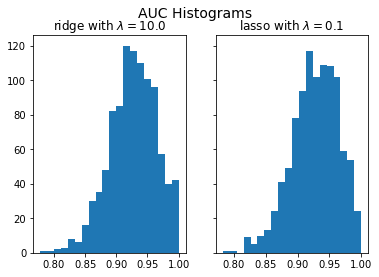

In [14]:
n_bins = 20

fig, axs = plt.subplots(1, 2, sharey=True)

axs[0].hist(ridge_aucs[ridge_aucs.mean().idxmax()].values, bins=n_bins)
axs[1].hist(lasso_aucs[lasso_aucs.mean().idxmax()].values, bins=n_bins)

fig.suptitle("AUC Histograms", fontsize=14)

def set_axis_title(ax, title):
    plt.sca(ax)
    plt.title(title)

set_axis_title(axs[0], "ridge with $\lambda=%.1f$"%lambda_vals[ridge_aucs.mean().idxmax()])
set_axis_title(axs[1], "lasso with $\lambda=%.1f$"%lambda_vals[lasso_aucs.mean().idxmax()])

### Confidence Intervals:

For getting the $p$ empirical confidence interval, we first sort all the values and then get the $\frac{1+p}{2}$ and $\frac{1-p}{2}$ percentiles:

In [15]:
def empirical_ci(vals, p):
    l_pval = (1-p)/2
    u_pval = (1+p)/2
    
    vals = np.array(vals)
    vals = np.sort(vals)
    
    l_idx = int(len(vals)*l_pval)
    u_idx = int(len(vals)*u_pval)
    
    return vals[l_idx], vals[u_idx]

In [16]:
p = 0.95

ridge_ci_l, ridge_ci_u = empirical_ci(ridge_aucs[ridge_aucs.mean().idxmax()], p)
lasso_ci_l, lasso_ci_u = empirical_ci(lasso_aucs[lasso_aucs.mean().idxmax()], p)

In [17]:
print ("ridge CI: (%.2f, %.2f)"%(ridge_ci_l, ridge_ci_u))
print ("lasso CI: (%.2f, %.2f)"%(lasso_ci_l, lasso_ci_u))

ridge CI: (0.85, 1.00)
lasso CI: (0.85, 0.99)
